In [96]:
pip install lmfit


  Obtaining dependency information for lmfit from https://files.pythonhosted.org/packages/38/7e/7b91c89a4cf0f543a83be978657afb20c86af6d725253e319589dcc4ce52/lmfit-1.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for asteval>=1.0 from https://files.pythonhosted.org/packages/13/ac/19dbba27e891f39feb4170b884da449ee2699ef4ebb88eefeda364bbbbcf/asteval-1.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for uncertainties>=3.2.2 from https://files.pythonhosted.org/packages/8f/5e/f1e1dd319e35e962a4e00b33150a8868b6329cc1d19fd533436ba5488f09/uncertainties-3.2.3-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/97.7 kB ? eta -:--:--
   ---------------------------------------- 97.7/97.7 kB 2.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/60.1 kB ? eta -:--:--
   ---------------------------------------- 60.1/60.1 kB ? eta 0:00:00


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lmfit

V_0 = 40 # Potential depth in MeV
a = 0.6 # Diffusivity, may want to check the vaidity of this paticular number
r_0 = 1.2 # In fm, may want to chose a better value for small nuclei
A_c = 10 # The number of nucleons in the core
BETA_1 = 0.05
BETA_2 = 0.075
BETA_3 = 0.1
BETA_4 = 0.125
BETA_5 = 0.15 # All in [fm]^-2, and are all initial guesses
BETA_INITIAL_GUESSES = [BETA_1, BETA_2, BETA_3, BETA_4, BETA_5]
INITAL_C_GUESS = 0.01

We want to define the function we are fitting to as well as the functions for the gaussians

In [151]:
def woods_saxon_potential(r, potential_depth=V_0, r_0=r_0, diffusivity=a, num_core_nucleons=A_c):
    R_0 = r_0 * num_core_nucleons**(1/3)
    return -1 * potential_depth / (1 + np.exp((r - R_0) / diffusivity))


def five_gaussian_potential(r, c_1, beta_1, c_2, beta_2, c_3, beta_3, c_4, beta_4, c_5, beta_5, potential_depth=V_0):
    """
    Defines our gaussian potential as a sum of 5 different potentials of the form V_0 e^(beta*r^2), for a set
    of beta.
    Input
    r : 1D array
    """
    return - (V_0) * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2) + c_3 * np.exp(
        -beta_3 * r**2) + c_4 * np.exp(-beta_4 * r**2) + c_5 * np.exp(-beta_5 * r**2))

def two_gaussian_potential(r, c_1, beta_1, c_2, beta_2, potential_depth=V_0):
    return -V_0 * (c_1 * np.exp(-beta_1 * r**2) + c_2 * np.exp(-beta_2 * r**2))

We now want to use curve fit to find a set of parameters 

In [147]:
r_values = np.linspace(0, 12, 1000000)

curve_fit_result, covariances = curve_fit(
        two_gaussian_potential, r_values, woods_saxon_potential(r_values), [INITAL_C_GUESS, BETA_1, INITAL_C_GUESS, BETA_2], maxfev=10000)
print(curve_fit_result)
#note: diagonal elements of the covariance matrix will give the variance on each fit parameter
errors = np.sqrt(np.diag(covariances))
print(errors)

[ 1.38197278e+02  7.79557362e-02 -1.37151160e+02  7.76845045e-02]
[9.55086869e+03 9.43781674e-03 9.55086877e+03 9.46865479e-03]


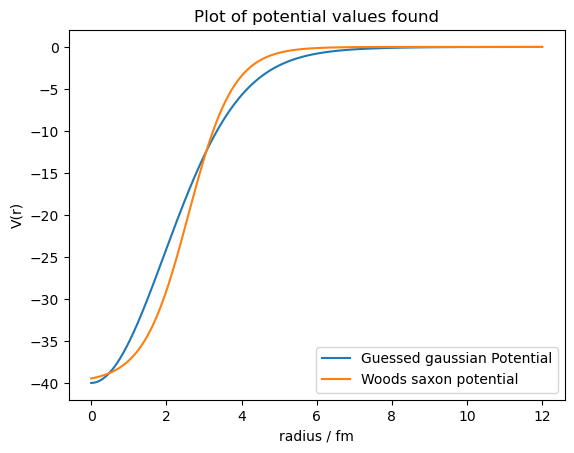

In [163]:
fig = plt.figure()
ax = fig.add_subplot()
x_values = np.linspace(1, 12, 1000)

C_1 = 0.05
C_2 = 0.05
C_3 = 0.1
C_4 = 0.3
C_5 = 0.5

ax.set_title('Plot of potential values found')
ax.set_xlabel('radius / fm')
ax.set_ylabel('V(r)')
# ax.plot(r_values, two_gaussian_potential(r_values, curve_fit_result[0], curve_fit_result[1], curve_fit_result[2], curve_fit_result[3]), label=f'Fited gaussian Potential')
ax.plot(r_values, five_gaussian_potential(r_values, C_1, BETA_1, C_2, BETA_2, C_3, BETA_3, C_4, BETA_4, C_5, BETA_5), label=f'Guessed gaussian Potential')
ax.plot(r_values, woods_saxon_potential(r_values), label='Woods saxon potential')
ax.legend(loc='lower right')

plt.savefig('potentials_plot.png', dpi=300)
plt.show()

BREAK HERE

In [112]:
def gaussian_potential_test(r, beta_1, beta_2, beta_3, beta_4, beta_5, potential_depth):
    """
    Defines our gaussian potential as a sum of 5 different potentials of the form V_0 e^(beta*r^2), for a set
    of beta.
    Input
    r : 1D array
    """

    return - (V_0 / 5) * (np.exp(-beta_1 * r**2) + np.exp(-beta_2 * r**2) + np.exp(-beta_3 * r**2) + np.exp(-beta_4 * r**2) + np.exp(
        -beta_5 * r**2))

fit_params = lmfit.Parameters()
fit_params.add('beta_1', value = 0.05)
fit_params.add('beta_2', value = 0.075)
fit_params.add('beta_3', value = 0.1)
fit_params.add('beta_4', value = 0.125)
fit_params.add('beta_5', value = 0.15)
fit_params.add('potential_depth', value = 40, vary=False)

gaussian_model = lmfit.Model(gaussian_potential_test)

result = gaussian_model.fit(woods_saxon_potential(r_values), fit_params, r=r_values)
#result = lmfit.minimize(gaussian_potential_test, fit_params, args=(r_values))
print(result.fit_report())

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.